In [23]:
import os
import matplotlib.pyplot as plt
import numpy as np
import itertools
from PIL import Image as im
from matplotlib.pyplot import figure
from glob import glob
from tqdm import tqdm

from random import randint
from razdel import tokenize
from typing import *
from utils import take_stripe, STRIPE_INTERVAL_UP, STRIPE_INTERVAL_DOWN, binarize, avg

In [2]:
with open(os.getcwd() + "/../dictation_text.txt") as f:
    text = f.read()
    dictation_text = [word.text.strip(",.") for word in tokenize(text)]
    dictation_text = [w for w in dictation_text if len(w) > 0]

In [3]:
DATA_LOCATION = "../chopped"
WORK_PATHS = glob(f"{DATA_LOCATION}/*/*")
work_path = WORK_PATHS[0]
work_path

'../chopped/58198/58198_4'

In [4]:
def take_notches(stripe_trimmed: np.array)-> 'List[int]':
    """from all columns of an 2D np.array save those that contain zero significant pixels"""
    notches_ = set()
    for idx, col in enumerate(stripe_trimmed.T):
        if np.sum(col) == 0:
            notches_.add(idx)
    return notches_

In [21]:
# how close should notches be to form a single group of "consecutive" empty lines
NOTCHES_DIFF_THRESHOLD = 10

def condense(notches) -> List[int]:
    condensed = []
    potential_group = []
    
    for notch in notches:
        if len(potential_group) == 0:
            potential_group.append(notch)
        elif notch - potential_group[-1] < NOTCHES_DIFF_THRESHOLD and notch != notches[-1]:
            potential_group.append(notch)
        else:
            condensed.append(int(avg(potential_group)))
            potential_group = []
    return condensed

condense_notches = condense

In [6]:
def trim(image, where='lrtb', return_trims=False):
    bin_img = binarize(image)
    height, width = bin_img.shape
    def find_border(bin_img):
        for (idx, row) in enumerate(bin_img):
            if np.sum(row) > 1:
                return idx
    
    left = find_border(bin_img.T) if 'l' in where  else 0
    right_raw = find_border(bin_img.T[::-1, :]) if 'r' in where else 0
    if right_raw is None:
        return None
    right = width - right_raw
    
    if return_trims:
        trims = {
            'l': left,
            'r': right,
        }
        return image.crop((left, 0, right, height)), trims
    return image.crop((left, 0, right, height))

def trim_bin(bin_img, where='lrtb', return_trims=False):
    height, width = bin_img.shape
    def find_border(bin_img):
        for (idx, row) in enumerate(bin_img):
            if np.sum(row) > 1:
                return idx
    
    left = find_border(bin_img.T) if 'l' in where  else 0
    right_raw = find_border(bin_img.T[::-1, :]) if 'r' in where else 0
    if right_raw is None:
        return None
    right = width - right_raw
    
    if return_trims:
        trims = {
            'l': left,
            'r': right,
        }
        return bin_img[:,left:right], trims
    return bin_img[:,left:right]

In [7]:
class Line:
    def __init__(self, path: str):
        self.path = path
        self.image = im.open(path)
        self.bin_img = binarize(self.image)

    def __repr__(self):
        return f"Line({self.path})"
    
    def __lt__(self, other):
        return self.path[-6:-4] < other.path[-6:-4]
    
class Page:
    def __init__(self, path: str):
        self.path = path
        self.lines = [Line(l) for l in glob(path + "/*.png")]
        self.lines.sort()

    def __repr__(self):
        return f"Page({self.path})"
    
    def __lt__(self, other):
        return self.path[-1] < other.path[-1]
    
class Work:
    def __init__(self, work_path: str):
        self.pages = [Page(p) for p in glob(f"{work_path}/*")]
        self.pages.sort()
        self.work_id = os.path.basename(work_path)

    @staticmethod
    def extract_work_id(filename: str) -> str:
        return filename.split('/')[-1].split('-')[0]
    
    def __repr__(self):
        return f"Work({self.work_id}, {self.pages})"

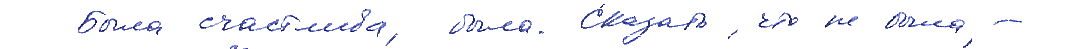

In [8]:
work = Work(WORK_PATHS[randint(0, len(WORK_PATHS)-1)])
page = work.pages[randint(0, len(work.pages)-1)]
line = page.lines[randint(0, len(page.lines)-1)]
line.image

In [9]:
figure(figsize=(50, 50))

trimmed_line, trims = trim(line.image, return_trims=True)

kernel = np.ones(20) / 20
projected_down = np.sum(binarize(trimmed_line), axis=0)
data_convolved_10 = np.convolve(projected_down, kernel, mode='same')
data_convolved_10 = np.convolve(data_convolved_10, kernel, mode='same')
print(np.average(data_convolved_10))
# plt.axhline(np.average(data_convolved_10), color='red')
# plt.plot(data_convolved_10)

1.9026605847004763


<Figure size 3600x3600 with 0 Axes>

In [10]:
from operator import itemgetter
def groupc(sequence):
    ranges = []
    for k,g in itertools.groupby(enumerate(sorted(sequence)),lambda x:x[0]-x[1]):
        group = (map(itemgetter(1),g))
        group = list(map(int,group))
        ranges.append(group)
    return ranges

def find_axis(line: np.array, q: int=75)-> int:
    """
    A line is projected on the y-axis (i.e. projected left), thus a distribution of pixels along y-axis is built.
    A `q`-percentile of this distribution is taken, indicating the horizontal lines where most of meaningful pixels
        are concentrated. It is possible that at the border of the distribution plot will surpass the percentile.
        To get rid of these pieces, all x's where y > percentile are split into continuous sequences. Then the 
        largest sequence is selected.
    """
    projected_left = np.sum(line, axis=1)
    percentile = np.percentile(projected_left, q).astype(np.int16)
    where_concentrated = np.where(projected_left > percentile)[0]
    sequences = groupc(where_concentrated)
    longest_sequence = max(sequences, key=lambda x: len(x))
    return min(longest_sequence), np.average(longest_sequence).astype(np.int16), max(longest_sequence)

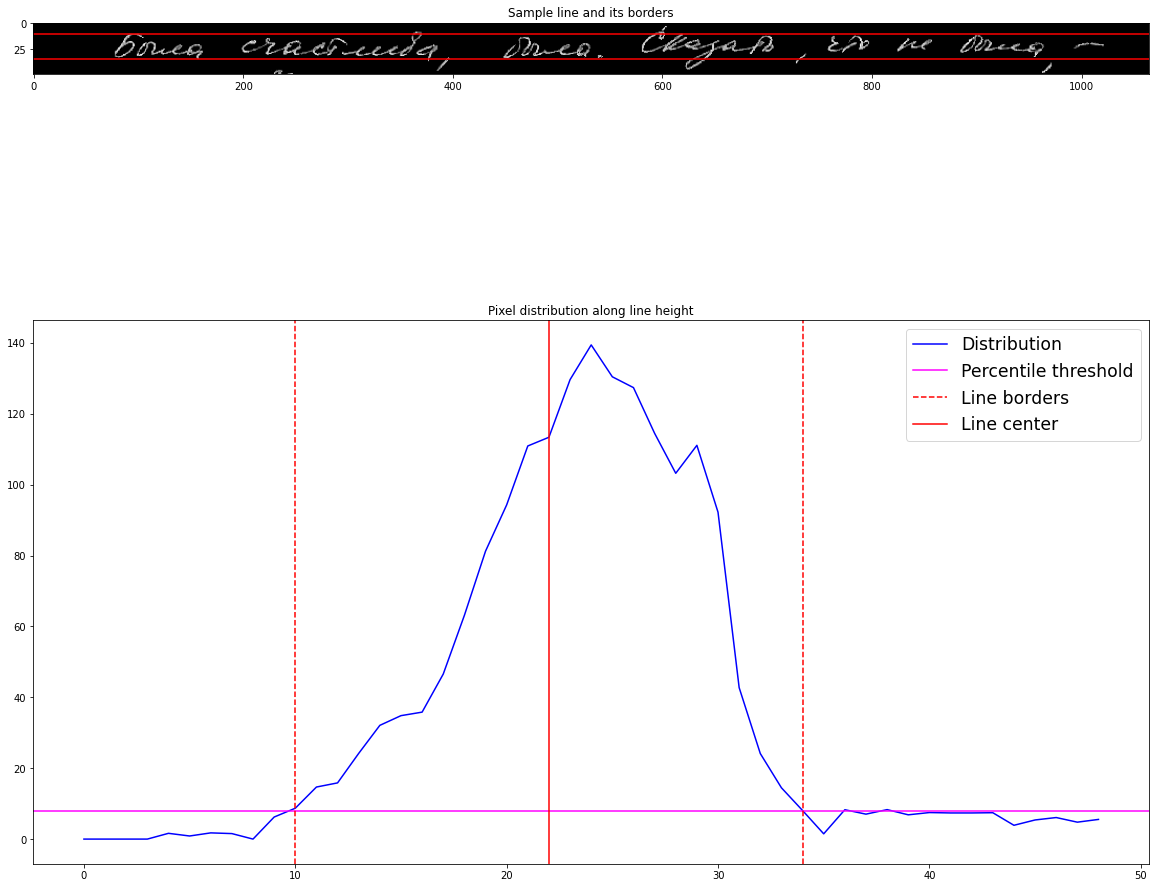

In [11]:
"""LOGIC BEHIND find_axis"""
figure(figsize=(20, 20))
plt.subplots_adjust(hspace=0)
# copy-paste
projected_left = np.sum(line.bin_img, axis=1)
percentile = np.percentile(projected_left, 50).astype(np.int16)
where_concentrated = np.where(projected_left > percentile)[0]
sequences = groupc(where_concentrated)
longest_sequence = max(sequences, key=lambda x: len(x))

ax = plt.subplot(2, 1, 1)
ax.set_title('Sample line and its borders')
plt.imshow(line.bin_img, cmap='gray')
plt.axhline(y=min(longest_sequence),color='red')
plt.axhline(y=max(longest_sequence), color='red')

ax = plt.subplot(2, 1, 2)
ax.set_title("Pixel distribution along line height")
plt.plot(projected_left, color='blue')
plt.axhline(y=percentile,color='magenta')
plt.axvline(x=min(longest_sequence),color='red', linestyle='dashed')
plt.axvline(x=np.average(longest_sequence).astype(np.int16), color='red')
plt.axvline(x=max(longest_sequence),color='red', linestyle='dashed')
plt.legend(["Distribution", "Percentile threshold", "Line borders", "Line center"], fontsize='xx-large')


In [12]:
WORK_PATHS[randint(0, len(WORK_PATHS)-1)]

'../chopped/57347/57347_37'

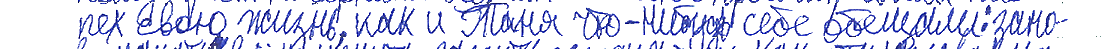

In [48]:
work = Work(WORK_PATHS[randint(0, len(WORK_PATHS)-1)])
page = work.pages[randint(0, len(work.pages)-1)]
line = page.lines[randint(0, len(page.lines)-1)]
line.image

4.666666666666667


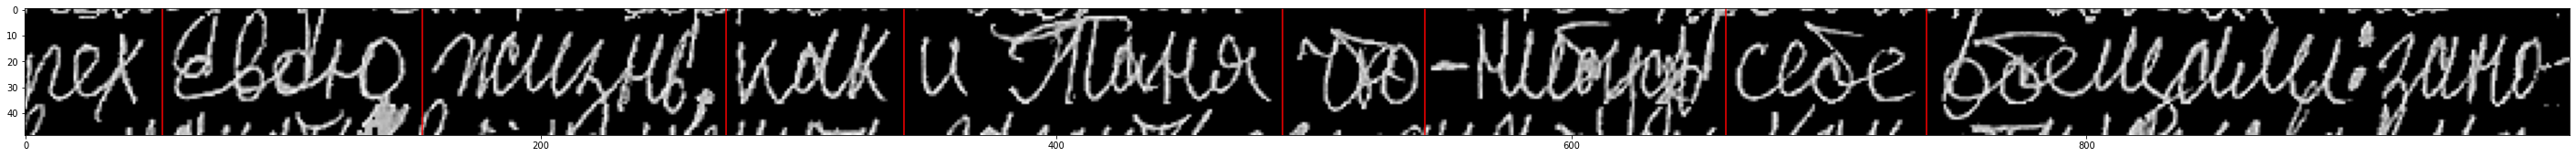

In [57]:
"""CONDENSED NOTCHES DEMO"""
h, w = line.bin_img.shape
figure(figsize=(50, 50))

minn, med, maxx = find_axis(line.bin_img, 50)

_, trims = trim_bin(line.bin_img[minn:maxx], return_trims=True)
upper_part = line.bin_img[:med, trims['l']:trims['r']]
middle_part = line.bin_img[minn:maxx, trims['l']:trims['r']]
lower_part = line.bin_img[med:, trims['l']:trims['r']]

lower_part_notches = take_notches(lower_part)
middle_part_notches = take_notches(middle_part)
upper_part_notches = take_notches(upper_part)

merged_notches = set()
for notch in lower_part_notches | middle_part_notches | upper_part_notches:
    in_up = notch in upper_part_notches
    in_mid = notch in middle_part_notches
    in_low =  notch in lower_part_notches
    if in_up + in_mid + in_low >= 2:
        merged_notches.add(notch)
    
continuous_notches = groupc(merged_notches)
empty_space_min_len = min(sum(map(len,continuous_notches)) / len(continuous_notches), 5)
# filter out small spaces
continuous_notches = list(filter(lambda x: len(x) > empty_space_min_len, continuous_notches))
print(empty_space_min_len)

flattened_notches = []
for list_ in continuous_notches:
    flattened_notches.extend(list_)
condensed_notches = condense(flattened_notches)

shown = line.bin_img[:,trims['l']:trims['r']]
plt.imshow(shown, 'gray')
for x in condensed_notches:
    plt.axvline(x=x,color='red')

In [58]:
MIN_EMPTY_SPACE_LEN = 5

def segment_line_into_words(line: Line):
    minn, med, maxx = find_axis(line.bin_img, 50)

    trim_result = trim_bin(line.bin_img[minn:maxx], return_trims=True)
    if trim_result is None:
        return []
    _, trims = trim_result
    trimmed_line_image = line.image.crop((trims['l'], 0, trims['r'], line.image.height))
    
    upper_part = line.bin_img[:med, trims['l']:trims['r']]
    middle_part = line.bin_img[minn:maxx, trims['l']:trims['r']]
    lower_part = line.bin_img[med:, trims['l']:trims['r']]

    lower_part_notches = take_notches(lower_part)
    middle_part_notches = take_notches(middle_part)
    upper_part_notches = take_notches(upper_part)

    merged_notches = set()
    for notch in lower_part_notches | middle_part_notches | upper_part_notches:
        in_up = notch in upper_part_notches
        in_mid = notch in middle_part_notches
        in_low =  notch in lower_part_notches
        if in_up and in_mid or in_low and in_mid:
            merged_notches.add(notch)

    continuous_notches = groupc(merged_notches)
    if len(continuous_notches) == 0:
        return [trimmed_line_image]
    empty_space_min_len = min(sum(map(len,continuous_notches)) / len(continuous_notches), MIN_EMPTY_SPACE_LEN)
    # filter out small spaces
    continuous_notches = list(filter(lambda x: len(x) > empty_space_min_len, continuous_notches))

    flattened_notches = []
    for list_ in continuous_notches:
        flattened_notches.extend(list_)
    condensed_notches = [0] + condense(flattened_notches) + [trimmed_line_image.width]

    words = []
    pairs = [(condensed_notches[i], condensed_notches[i+1]) for i in range(len(condensed_notches) - 1)]
    for l, r in pairs:
        words.append(trimmed_line_image.crop((l, 0, r, line.image.height)))
    return words

In [144]:
def extract_words(work):
    for page in work.pages:
        for line in page.lines:
            line_num = os.path.basename(line.path).replace(".png", "")
            destination = f"../formatted_data/words/{work.work_id}/{os.path.basename(page.path)}/{line_num}"
            os.makedirs(destination, exist_ok=True)
            words = segment_line_into_words(line)
            for i, word in enumerate(words):
                stripe = take_stripe(word)
                trimmed = trim(stripe, return_trims=True)
                if trimmed is None:
                    continue
                _, trims = trimmed
                word.crop((trims['l'],0,trims['r'],word.height)). \
                    convert("RGB"). \
                    save(f"{destination}/{i}.jpg")
                
for work in tqdm((Work(path) for path in WORK_PATHS), total=514):
    extract_words(work)

100%|█████████████████████████████████████████| 514/514 [08:22<00:00,  1.02it/s]


#### Alignment baseline

In [146]:
len(dictation_text)

300

In [147]:
def alignment_baseline(work: Work):
    text_generator = enumerate(dictation_text)
    source = f"/home/arcamu/Documents/Uni/Disser/formatted_data/words/{work.work_id}"
    images = glob(f"{source}/**/*.jpg", recursive=True)
    
    destination = f"../formatted_data/word_alignment/{work.work_id}/"
    os.makedirs(destination, exist_ok=True)
    i = 0
    images.sort(key=lambda path: int(path.split('/')[-1].replace(".jpg", "")))
    images.sort(key=lambda path: int(path.split('/')[-2]))
    images.sort(key=lambda path: int(path.split('/')[-3][-1]))
    for image_path in images:
        next_word = next(text_generator, None)
        if next_word is None:
            return
        image = im.open(image_path)
        i, word = next_word
        image.convert("RGB").save(f"{destination}/{i}_{word}.jpg")

for work in tqdm((Work(path) for path in WORK_PATHS), total=514):
    alignment_baseline(work)

100%|█████████████████████████████████████████| 514/514 [02:38<00:00,  3.24it/s]


### Trying to remove little stuff from image borders

In [2]:
""" HOUGH lines don't work """

# open_cv_image = np.array(words[1])[:, :, ::-1]
# open_cv_image = cv2.Canny(open_cv_image, 50, 200, None, 3)

# cdst = cv2.cvtColor(open_cv_image, cv2.COLOR_GRAY2BGR)
# cdstP = np.copy(cdst)

# lines = cv2.HoughLinesP(open_cv_image, 1, np.pi / 180, 50, None, 50, 10)
# print(lines)
# if lines is not None:
#     for i in range(0, len(lines)):
#         l = lines[i][0]
#         cv2.line(cdstP, (l[0], l[1]), (l[2], l[3]), (0,0,255), 3, cv2.LINE_AA)

# plt.imshow(cdstP)

" HOUGH lines don't work "

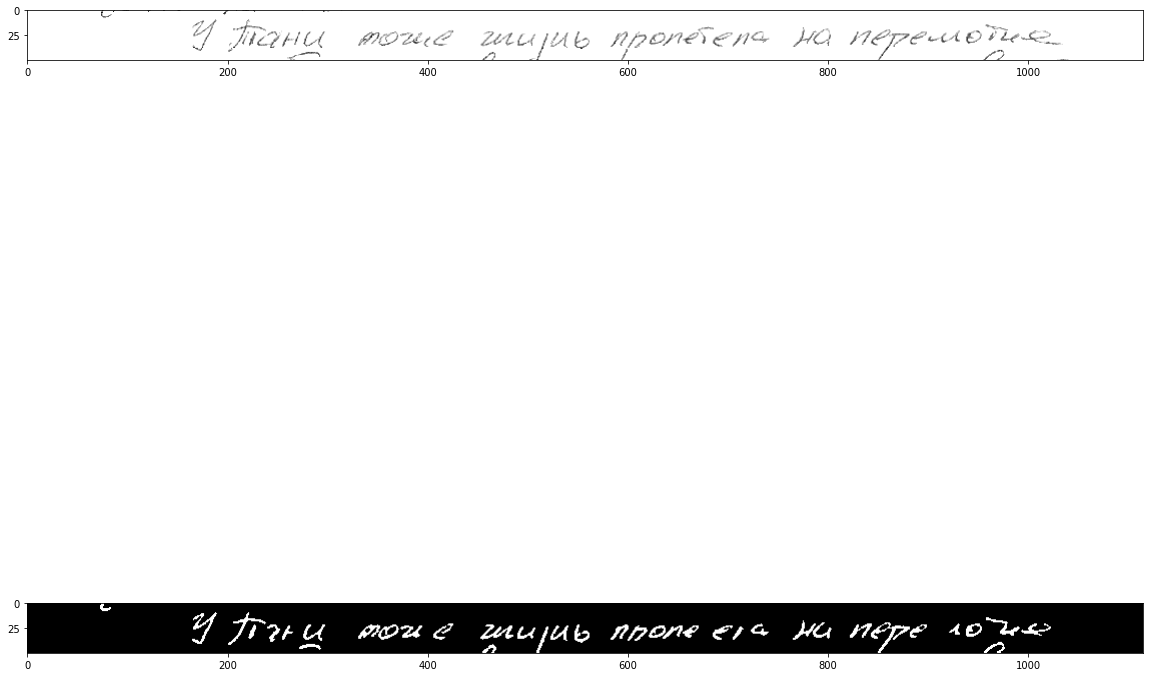

In [117]:
""" DELETE BY CONTOUR. DOESN'T WORK CUZ LETTERS CAN BE TOO SMALL"""
figure(figsize=(20, 20))
import cv2

# Load image, convert to grayscale, Gaussian blur, Otsu's threshold
image = np.array(line.image)[:, :, ::-1]
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
blur = cv2.GaussianBlur(gray, (3,3), 1)
thresh = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]

# Filter using contour area and remove small noise
cnts = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
cnts = cnts[0] if len(cnts) == 2 else cnts[1]
for c in cnts:
    area = cv2.contourArea(c)
    if area < 30:
        cv2.drawContours(thresh, [c], -1, (0,0,0), -1)

# Morph close and invert image
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5,5))
close = 255 - cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel, iterations=2)
plt.subplot(2, 1, 1)
plt.imshow(gray, cmap='gray')
plt.subplot(2, 1, 2)
plt.imshow(thresh, cmap='gray')

In [4]:
""" FLOOD FILL ELEMENTS THAT ARE ON BORDER """

# figure(figsize=(20, 20))

# floodFilled = gray.copy()
# _, floodFilled = cv2.threshold(floodFilled, thresh=180, maxval=255, type=cv2.THRESH_BINARY)
# for id in list(id for id, x in enumerate(floodFilled[1]) if x == 0):
#     cv2.floodFill(floodFilled, None,(id,1),255)
# plt.imshow(floodFilled, cmap="gray")

' FLOOD FILL ELEMENTS THAT ARE ON BORDER '